In [1]:
library(ggplot2)
library(ggpubr)
library(corrplot)
library(RColorBrewer)
library(ggrepel)
library(argparse)
library(Matrix)
library(data.table)
library(dplyr)
library(circlize)
library(ggrepel)
library(ComplexUpset)


options(bitmapType = 'cairo', device = 'png')
Sys.setlocale("LC_NUMERIC", "C")

setwd('/psycl/g/mpsziller/lucia/')
color_tissues <- fread('priler_project/Figure_CASTom-iGEx_paper/color_tissues.txt', h=T, stringsAsFactors=F, data.table = F)
outFold <- "priler_project/Figure_CASTom-iGEx_paper/CAD_downsampling/"
source('priler_project/Figure_CASTom-iGEx_paper/Functions_prediction_plots.R')



corrplot 0.92 loaded


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


circlize version 0.4.13
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




[1] "C"

In [2]:
### functions ####

# load results 
load_res <- function(fold, tissue){
    
    df <- read.delim(sprintf('%s/resPrior_regEval_allchr.txt', fold), h=T, stringsAsFactors = F, sep = '\t')
    df$tissue <- tissue
    df$n_regSNPs <- NA
    
    # reg-SNPs per gene, regardless category
    coef <- get(load(sprintf('%s/resPrior_regCoeffSnps_allchr.RData', fold)))
    for(id_chr in 1:length(coef)){
        n_snps <- colSums(coef[[id_chr]]!=0)
        df$n_regSNPs[df$chrom == paste0('chr', id_chr)] <- n_snps
    }
    df$n_regSNPs[is.na(df$dev)] <- NA
    
    return(df)
}

anotate_genes_topath <- function(output_assoc, type_path, id_pheno = 1){
    
    if(type_path == "Reactome"){
     path <- output_assoc$pathScore_reactome[[id_pheno]]        
     info <- output_assoc$info_pathScore_reactome[[id_pheno]]   
     id_pval <- 13
    }
    if(type_path == "GO"){
     path <- output_assoc$pathScore_GO[[id_pheno]]        
     info <- output_assoc$info_pathScore_GO[[id_pheno]]   
     id_pval <- 15
    }
    if(type_path == "custom"){
     path <- output_assoc$pathScore[[id_pheno]]        
     info <- output_assoc$info_pathScore[[id_pheno]]   
     id_pval <- 13   
    }
    
    path$genes <- sapply(info, function(x) paste0(x$tscore$external_gene_name, collapse = ","))
    path$improvement_path <- sapply(info, function(x) all(info[[id_pheno]]$tscore[,8] >= info[[id_pheno]]$path[,id_pval]))
    
    return(path)
}

load_assoc_res <- function(fold, id_pheno = 1){
    
    output <- get(load(sprintf('%spval_CAD_pheno_covCorr.RData', fold)))
    df_tscore <- output$tscore[[id_pheno]]
    df_pathR <- anotate_genes_topath(output, type_path = "Reactome", id_pheno = id_pheno) %>%
        dplyr::filter(ngenes_tscore >= 2)  
    df_pathR[, 15] <- p.adjust(df_pathR[, 13], method = "BH")
    
    df_pathGO <- anotate_genes_topath(output, type_path = "GO", id_pheno = id_pheno) %>%
      dplyr::filter(ngenes_tscore >= 2)  
    df_pathGO[, 17] <- p.adjust(df_pathGO[, 15], method = "BH")

    output <- get(load(sprintf('%spval_CAD_pheno_covCorr_customPath_WikiPath2019Human.RData', fold)))
    df_pathWiki <- anotate_genes_topath(output, type_path = "custom", id_pheno = id_pheno) %>%
              dplyr::filter(ngenes_tscore >= 2)  
    df_pathWiki[, 15] <- p.adjust(df_pathWiki[, 13], method = "BH")

    return(list(gene = df_tscore, Reactome = df_pathR, GO = df_pathGO, Wiki = df_pathWiki))
}
                                    
pl_corr <- function (res_cor, type_mat, tissues_name,
    outFold, width_pl = 10, height_pl = 7){
    
    diag(res_cor$cor) <- NA
    col <- colorRampPalette(brewer.pal(9, "Oranges"))(100)
    ord <- corrMatOrder(res_cor$cor, order = "hclust", hclust.method = "ward.D")

    pdf(file = sprintf("%scorr_zscore_%s.pdf", outFold, type_mat), 
        width = width_pl, height = height_pl, compress = F)
    corrplot(res_cor$cor, type = "upper", order = "hclust", hclust.method = "ward.D", 
        tl.col = "black", col = c(col), 
        method = "color", tl.srt = 45, cl.align.text = "c", addCoef.col = "black", 
        na.label = "square", na.label.col = "darkgrey", is.corr = F)
    dev.off()
   
    diag(res_cor$perc) <- NA
    col <- colorRampPalette(brewer.pal(9, "Greens"))(100)
    
    pdf(file = sprintf("%sperc_zscore_%s.pdf", outFold, type_mat), 
        width = width_pl, height = height_pl, compress = F)
    corrplot(res_cor$perc[ord, ord], type = "lower", tl.col = "black", 
        col = c(col), method = "color", tl.srt = 45, 
        cl.align.text = "c", addCoef.col = "black", na.label = "square", 
        na.label.col = "darkgrey", is.corr = F, number.cex = 1)
    dev.off()
   
}                                    



In [3]:
tissues <- c("Artery_Aorta", "Heart_Left_Ventricle")
perc <- c(50, 70, 90)
common_name <- "PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2_CAD_UKBB/"
folder_train <- sapply(tissues, function(x) sapply(perc, function(y)
    sprintf("%s/%s/200kb/downsampling/perc%s/CAD_GWAS_bin5e-2/", common_name, x, y)))
folder_train <- as.vector(folder_train)
folder_train <- c(folder_train,  sprintf("%s/%s/200kb/CAD_GWAS_bin5e-2/", common_name, tissues))

common_name <- "CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/"
folder_assoc <- sapply(tissues, function(x) sapply(perc, function(y) 
    sprintf('%s/%s/200kb/CAD_GWAS_bin5e-2/UKBB/downsampling/perc%i/devgeno0.01_testdevgeno0/', 
        common_name, x, y)))
folder_assoc <- c(folder_assoc, 
                  sprintf("%s/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/", common_name, tissues))
                                                                                           
                                                                                       
name_t <- sapply(tissues, function(x) sapply(perc, function(y)
    sprintf("%s (%s%%)", x, y))) %>% as.vector()
name_t <- c(name_t, sprintf("%s (100%%)", tissues))      
                                             
folder_sample <- sapply(tissues, function(x) sapply(perc, function(y)
    sprintf("PriLer_PROJECT_GTEx/INPUT_DATA/Covariates/%s/covariates_EuropeanSamples_downsample%s.txt", x, y))) %>%
    as.vector()
folder_sample <- c(folder_sample, sprintf("PriLer_PROJECT_GTEx/INPUT_DATA/Covariates/%s/covariates_EuropeanSamples.txt", tissues))
                                                   
tissues_model <- data.frame(tissue = name_t, 
                            folder_sample = folder_sample, 
                            folder_train = folder_train, 
                            folder_assoc = folder_assoc)


In [4]:
df <- list()
for(i in 1:nrow(tissues_model)){
    print(i)
    tmp <- load_res(fold = tissues_model$folder_train[i], tissue = tissues_model$tissue[i])
    df[[i]] <- tmp
}
col_keep <- names(which(table(unlist(sapply(df, colnames))) == length(df)))
df <- lapply(df, function(x) x[, colnames(x) %in% col_keep])
df <- do.call(rbind, df)
df$reliable <- F
df$reliable[df$test_dev_geno>0 & df$dev_geno>0.01] <- T
df_gene <- df
                               


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8


In [5]:
df_summary <- df_gene %>% 
    group_by(tissue) %>% 
    summarise(n_genes = sum(reliable)) %>% 
    mutate(n_regSNPs = NA, frac_prior = NA, n_samples = NA)
df_summary <- df_summary[match(tissues_model$tissue, df_summary$tissue),]

for(i in 1:nrow(tissues_model)){
    
    tmp <- read.delim(sprintf('%snVariants_prior_compare.txt', tissues_model$folder_train[i]),
                      h=T, stringsAsFactors = F)
    
    df_summary$n_regSNPs[i] <- sum(tmp$len[tmp$type == 'el-net learned prior'])
    
    df_summary$frac_prior[i] <- sum(tmp$len[tmp$type == 'el-net learned prior' & tmp$type_snp %in% c('with prior (common)', 'with prior (unique)')])/df_summary$n_regSNPs[i]
    
    tmp <- read.table(tissues_model$folder_sample[i], h=T, stringsAsFactors = F)
    df_summary$n_samples[i] <- nrow(tmp)
    
}

df_summary <- df_summary %>% rename(complete_name = tissue)
df_summary$tissue <- unname(sapply(df_summary$complete_name, function(x) strsplit(x, split = "[ ()]")[[1]][1]))
df_summary$percentage <- as.numeric(sapply(df_summary$complete_name, function(x) strsplit(x, split = "[(%)]")[[1]][2]))   
df_summary <- df_summary %>% arrange(tissue, percentage)
rownames(df_summary) <- NULL 
df_summary$percentage <- paste0(df_summary$percentage, "%")                                           
df_summary                                           
write.table(sprintf("%ssummary.tsv", outFold), x = df_summary, quote = F, sep = "\t", col.names = T, row.names = F)                                           

complete_name,n_genes,n_regSNPs,frac_prior,n_samples,tissue,percentage
<chr>,<int>,<int>,<dbl>,<int>,<chr>,<chr>
Artery_Aorta (50%),1849,314964,0.3681976,92,Artery_Aorta,50%
Artery_Aorta (70%),3319,300690,0.4021318,130,Artery_Aorta,70%
Artery_Aorta (90%),4443,303159,0.3967126,166,Artery_Aorta,90%
Artery_Aorta (100%),4841,330527,0.3843045,185,Artery_Aorta,100%
Heart_Left_Ventricle (50%),1522,287111,0.3385973,86,Heart_Left_Ventricle,50%
Heart_Left_Ventricle (70%),2281,269376,0.3898788,120,Heart_Left_Ventricle,70%
Heart_Left_Ventricle (90%),3067,262273,0.3892318,155,Heart_Left_Ventricle,90%
Heart_Left_Ventricle (100%),3305,267699,0.3846410,172,Heart_Left_Ventricle,100%


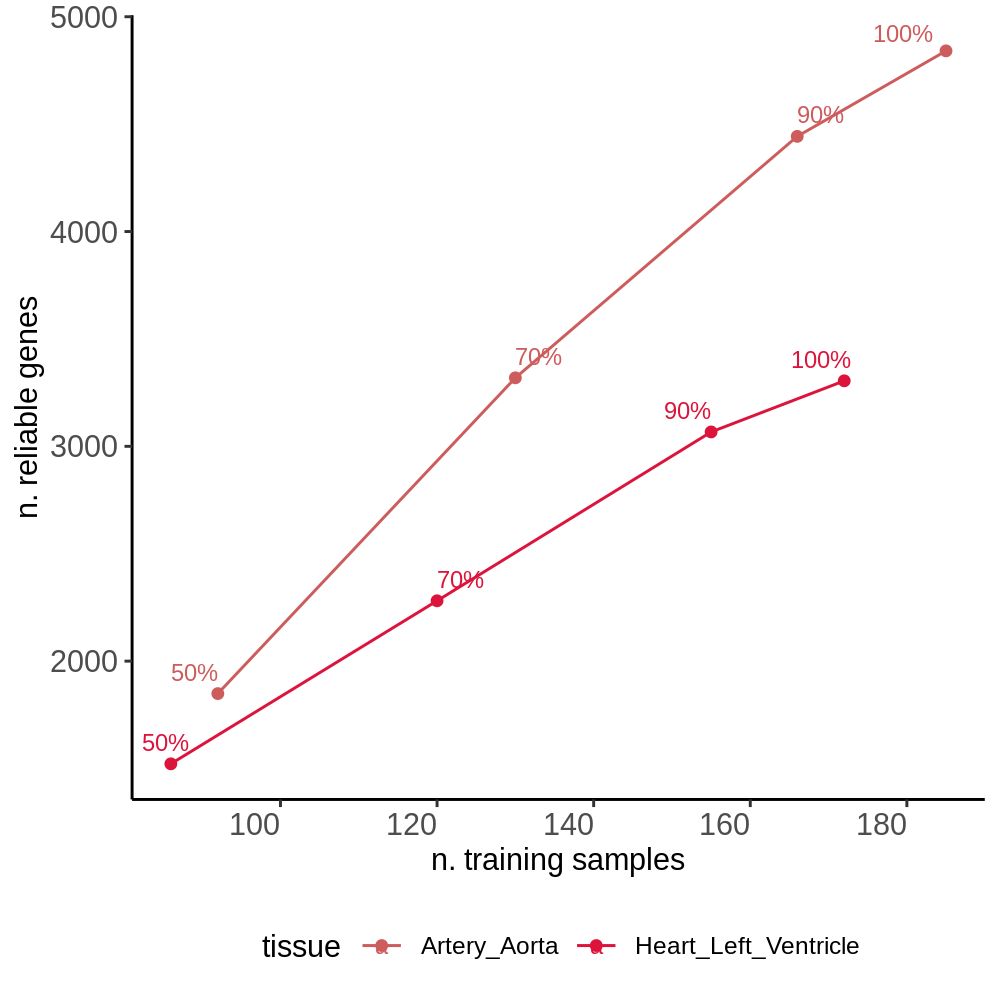

In [6]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)

col_plot <- color_tissues %>% filter(tissues %in% unique(df_summary$tissue))

pl_nrel <- ggplot(df_summary, aes(x = n_samples, y = n_genes, 
                                  color = tissue, group = tissue, 
                                  label = percentage)) + 
  geom_point(alpha = 2)+
  geom_line()+
  xlab('n. training samples')+ ylab('n. reliable genes') + 
  theme_classic()+
  geom_text_repel(size = 3, alpha = 1, nudge_y = 1, 
                  segment.size = 0.2)+
  theme(plot.title = element_text(hjust = 0.5, size = 12), text = element_text(size = 11),
        axis.text.x=element_text(size = 11, angle = 0, hjust = 1),
        axis.text.y=element_text(size = 11), legend.position = 'bottom')+
  scale_color_manual(values = col_plot$color)      

pl_nreg <- ggplot(df_summary, aes(x = n_samples, y = frac_prior, 
                                  color = tissue, group = tissue, 
                                  label = percentage)) + 
  geom_point(alpha = 2)+
  geom_line()+
  xlab('n. training samples')+ ylab('n. reg-SNPs') + 
  theme_classic()+
  geom_text_repel(size = 3, alpha = 1, nudge_y = 2, 
                  segment.size = 0.2)+
  theme(plot.title = element_text(hjust = 0.5, size = 12), text = element_text(size = 11),
        axis.text.x=element_text(size = 11, angle = 0, hjust = 1),
        axis.text.y=element_text(size = 11), legend.position = 'bottom')+
  scale_color_manual(values = col_plot$color)  

pl_nrel

ggsave(filename = sprintf("%sntrain_nrel.pdf", outFold), 
       plot = pl_nrel, width = 4, height = 4)

In [7]:
plot_R2_dist <- function(tissue_tmp, df_gene, save_file = NULL){
    
id <- names(which(table(df_gene$ensembl_gene_id[df_gene$reliable]) == length(unique(df_gene$tissue))))
df_plot <- df_gene
df_plot$tissue_name <- df_plot$tissue
df_plot$tissue_name <- factor(df_plot$tissue_name, 
                              levels = df_summary$complete_name[df_summary$tissue == tissue_tmp])

df_med <- df_plot %>% 
          filter(reliable) %>%
          group_by(tissue_name) %>% 
          summarise(med = median(dev_geno), med_test = median(test_dev_geno))

pl_box_R2 <- ggplot(subset(df_plot, reliable), 
                    aes(x = tissue_name, y=dev_geno)) + 
  geom_boxplot(width = 0.5, outlier.size = 0.3, alpha = 0.7, size = 0.3, 
               fill = col_plot$color[col_plot$tissue == tissue_tmp])+ 
  ylab(expression(R^2))+ ggtitle('')+
  xlab('')+ theme_bw()+ 
  ggtitle('Final model\n ')+
  geom_line(size = 1, data = df_med, mapping = aes(x = tissue_name, y = med, group=1), 
            color = 'grey80')+
  #scale_y_continuous(trans=weird)+
  geom_hline(yintercept = 0, color = 'darkgrey', linetype='dashed')+
  theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5), 
        text = element_text(size = 10),
        axis.text.y=element_text(size = 9, angle = 0, hjust = 1),
        axis.text.x=element_text(size = 10), legend.position = 'none')+
        coord_flip()

pl_box_R2_test <- ggplot(subset(df_plot, reliable), 
                    aes(x = tissue_name, y=test_dev_geno)) + 
  geom_boxplot(width = 0.5, outlier.size = 0.3, alpha = 0.7, size = 0.3, 
               fill = col_plot$color[col_plot$tissue == tissue_tmp])+ 
  ylab(expression(R[CV]^2))+ 
  xlab('')+ theme_bw()+ 
  geom_line(size = 1, data = df_med, mapping = aes(x = tissue_name, y = med_test, group=1), 
            color = 'grey80')+
  #scale_y_continuous(trans=weird)+
  ggtitle('All genes')+
  geom_hline(yintercept = 0, color = 'darkgrey', linetype='dashed')+
  theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5), 
        text = element_text(size = 12),
        #axis.text.y=element_blank(),
        axis.text.x=element_text(size = 10), legend.position = 'none')+
        coord_flip()

# common genes
df_med_c <- df_plot %>% 
          filter(reliable, ensembl_gene_id %in% id) %>%
          group_by(tissue_name) %>% 
          summarise(med = median(dev_geno), med_test = median(test_dev_geno))
df_med_c
pl_box_R2_c <- ggplot(subset(df_plot, reliable & ensembl_gene_id %in% id), 
                    aes(x = tissue_name, y=dev_geno)) + 
  geom_boxplot(width = 0.5, outlier.size = 0.3, alpha = 0.7, size = 0.3, 
               fill = col_plot$color[col_plot$tissue == tissue_tmp])+ 
  ylab(expression(R^2))+ 
  xlab('')+ theme_bw()+ 
  scale_fill_manual(values = col_plot$color[col_plot$tissue == tissue_tmp])+
  ggtitle(sprintf('Final model\n(%i common genes)', length(id)))+
  geom_line(size = 1, data = df_med_c, mapping = aes(x = tissue_name, y = med, group=1), 
            color = 'grey80')+
  #scale_y_continuous(trans=weird)+
  geom_hline(yintercept = 0, color = 'darkgrey', linetype='dashed')+
  theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5), 
        text = element_text(size = 10),
        axis.text.y=element_text(size = 12, angle = 0, hjust = 1),
        axis.text.x=element_text(size = 10), legend.position = 'none')+
        coord_flip()

pl_box_R2_test_c <- ggplot(subset(df_plot, reliable & ensembl_gene_id %in% id), 
                    aes(x = tissue_name, y=test_dev_geno)) + 
  geom_boxplot(width = 0.5, outlier.size = 0.3, alpha = 0.7, size = 0.3, 
               fill = col_plot$color[col_plot$tissue == tissue_tmp])+ 
  ylab(expression(R[CV]^2))+ 
  xlab('')+ theme_bw()+ 
  geom_line(size = 1, data = df_med_c, 
            mapping = aes(x = tissue_name, y = med_test, group=1), 
            color = 'grey80')+
  #scale_y_continuous(trans=weird)+
  ggtitle(sprintf('%i common genes', length(id)))+
  geom_hline(yintercept = 0, color = 'darkgrey', linetype='dashed')+
  theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5), 
        text = element_text(size = 12),
        axis.text.y=element_blank(),
        axis.text.x=element_text(size = 10), legend.position = 'none')+
        coord_flip()


    tot_pl <- ggarrange(plotlist = list(pl_box_R2_test, pl_box_R2_test_c), 
                    ncol = 2, nrow = 1, widths = c(1, 0.8))

    if(!is.null(save_file)){
        ggsave(filename = save_file, plot = tot_pl, width = 8, height = 2)
        
    }
    return(tot_pl)
}



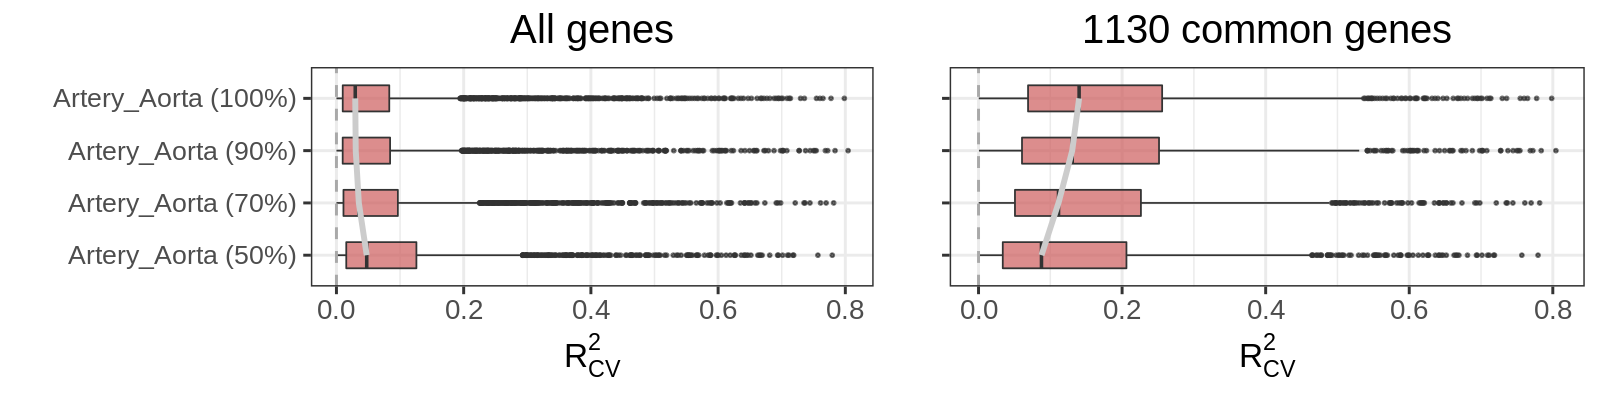

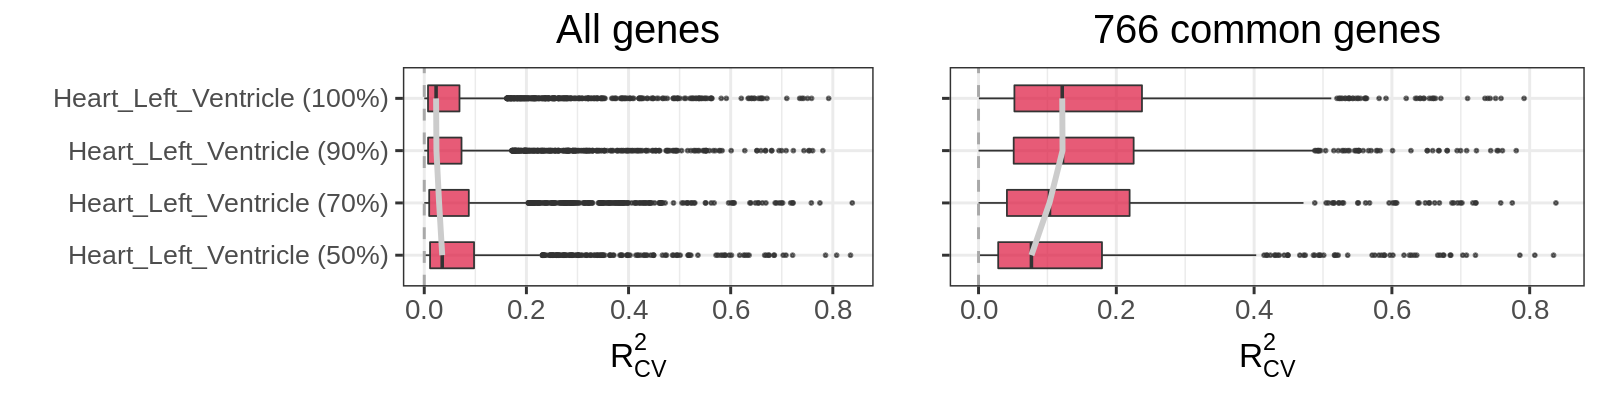

In [8]:
options(repr.plot.width = 8, repr.plot.height = 2, repr.plot.res = 200)

df_gene_list <- list(Artery_Aorta = df_gene[grepl("Artery_Aorta", df_gene$tissue),], 
                     Heart_Left_Ventricle = df_gene[grepl("Heart_Left_Ventricle", df_gene$tissue),])

plot_R2_dist(tissue_tmp = names(df_gene_list)[1], df_gene = df_gene_list[[1]], 
             save_file = sprintf("%sAA_R2C.pdf", outFold))
 
plot_R2_dist(tissue_tmp = names(df_gene_list)[2], df_gene = df_gene_list[[2]], 
              save_file = sprintf("%sHLV_R2C.pdf", outFold)) 
             


In [9]:
tscore <- pathR <- pathGO <- pathWiki <- list()
for(i in 1:nrow(tissues_model)){
    print(i)
    tmp <- load_assoc_res(fold = tissues_model$folder_assoc[i])
    
    tscore[[i]] <- tmp$gene %>% dplyr::mutate(tissue = tissues_model$tissue[i])
    pathR[[i]] <- tmp$Reactome %>% dplyr::mutate(tissue = tissues_model$tissue[i])
    pathGO[[i]] <- tmp$GO %>% dplyr::mutate(tissue = tissues_model$tissue[i])
    pathWiki[[i]] <- tmp$Wiki %>% dplyr::mutate(tissue = tissues_model$tissue[i])
}

tscore <- tscore %>% dplyr::bind_rows()
pathR <- pathR %>% dplyr::bind_rows()
pathGO <- pathGO %>% dplyr::bind_rows()
pathWiki <- pathWiki %>% dplyr::bind_rows()
# combine pathway inf
pathGO_filt <- pathGO %>% dplyr::select(-path_id, -path_ont)
path_tot <- rbind(pathR, pathGO_filt, pathWiki)

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8


In [10]:
tissues_id <- tissues_model$tissue

tscore_cor <- create_cor(tissues_name = tissues_id, res = tscore, id_z = 7)
path_cor <- create_cor(tissues_name = tissues_id, res = path_tot, id_z = 12)

pl_corr(tscore_cor, type_mat = "tscore", 
        tissues_name = tissues_id, 
        outFold = outFold, 
        width_pl = 8, height_pl = 8)

pl_corr(path_cor, type_mat = "pathway_tot", 
        tissues_name = tissues_id, 
        outFold = outFold, 
        width_pl = 8, height_pl = 8)


Warning message in cor.test.default(x[, id_z], y[, id_z], method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x[, id_z], y[, id_z], method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x[, id_z], y[, id_z], method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x[, id_z], y[, id_z], method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x[, id_z], y[, id_z], method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x[, id_z], y[, id_z], method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x[, id_z], y[, id_z], method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x[, id_z], y[, id_z], method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.defa

png 
  2

png 
  2

In [11]:
plot_upset <- function(df,type_dat, pheno_name, tissue_name, title_plot, save_file = NULL, hpl = 4, wpl = 8){
    
    if(type_dat == "tscore"){
        id <- "ensembl_gene_id"
    }else{
        id <- "path"
    }
    
    tmp <- df %>% 
        dplyr::filter(grepl(tissue_name, tissue), 
                      get(sprintf("%s_BHcorr", pheno_name)) <= 0.05) %>%
        dplyr::group_by(get(id)) %>%
        dplyr::summarise(tissue = paste0(tissue, collapse = ",")) %>%
        dplyr::mutate(tissues = stringr::str_extract_all(tissue, "50%|70%|90%|100%")) %>%
        dplyr::rowwise() %>%
        dplyr::mutate(t50 = as.numeric("50%" %in% tissues)) %>%
        dplyr::mutate(t70 = as.numeric("70%" %in% tissues)) %>%
        dplyr::mutate(t90 = as.numeric("90%" %in% tissues)) %>%
        dplyr::mutate(t100 = as.numeric("100%" %in% tissues)) %>%
        dplyr::select(-tissue,-tissues) 
    colnames(tmp)[-1] <- tissues_model$tissue[grepl(tissue_name, tissues_model$tissue)]
    tissues_tmp <- colnames(tmp)[-1] 
    pl <- upset(tmp, tissues_tmp, sort_intersections_by='degree', width_ratio=0.15) + ggtitle(title_plot) +
        theme(axis.text = element_text(size = 12)) 
   
    
    if(!is.null(save_file)){
        ggsave(pl, filename = save_file, width = wpl, height = hpl)
    }
    
    return(pl)
}



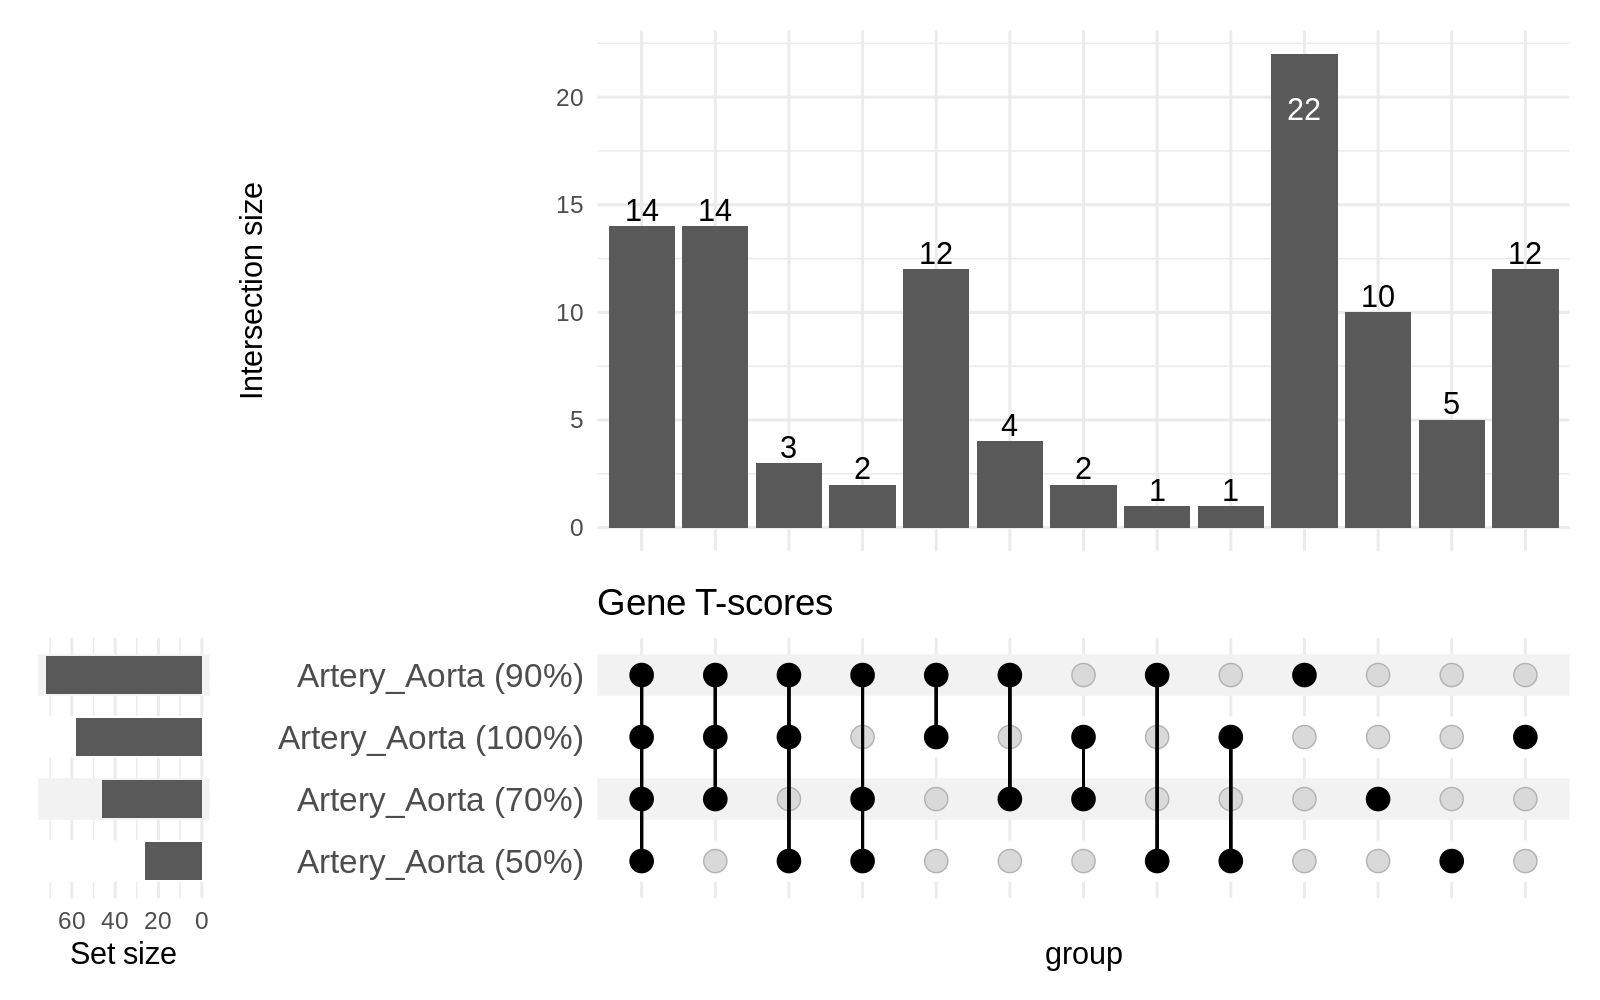

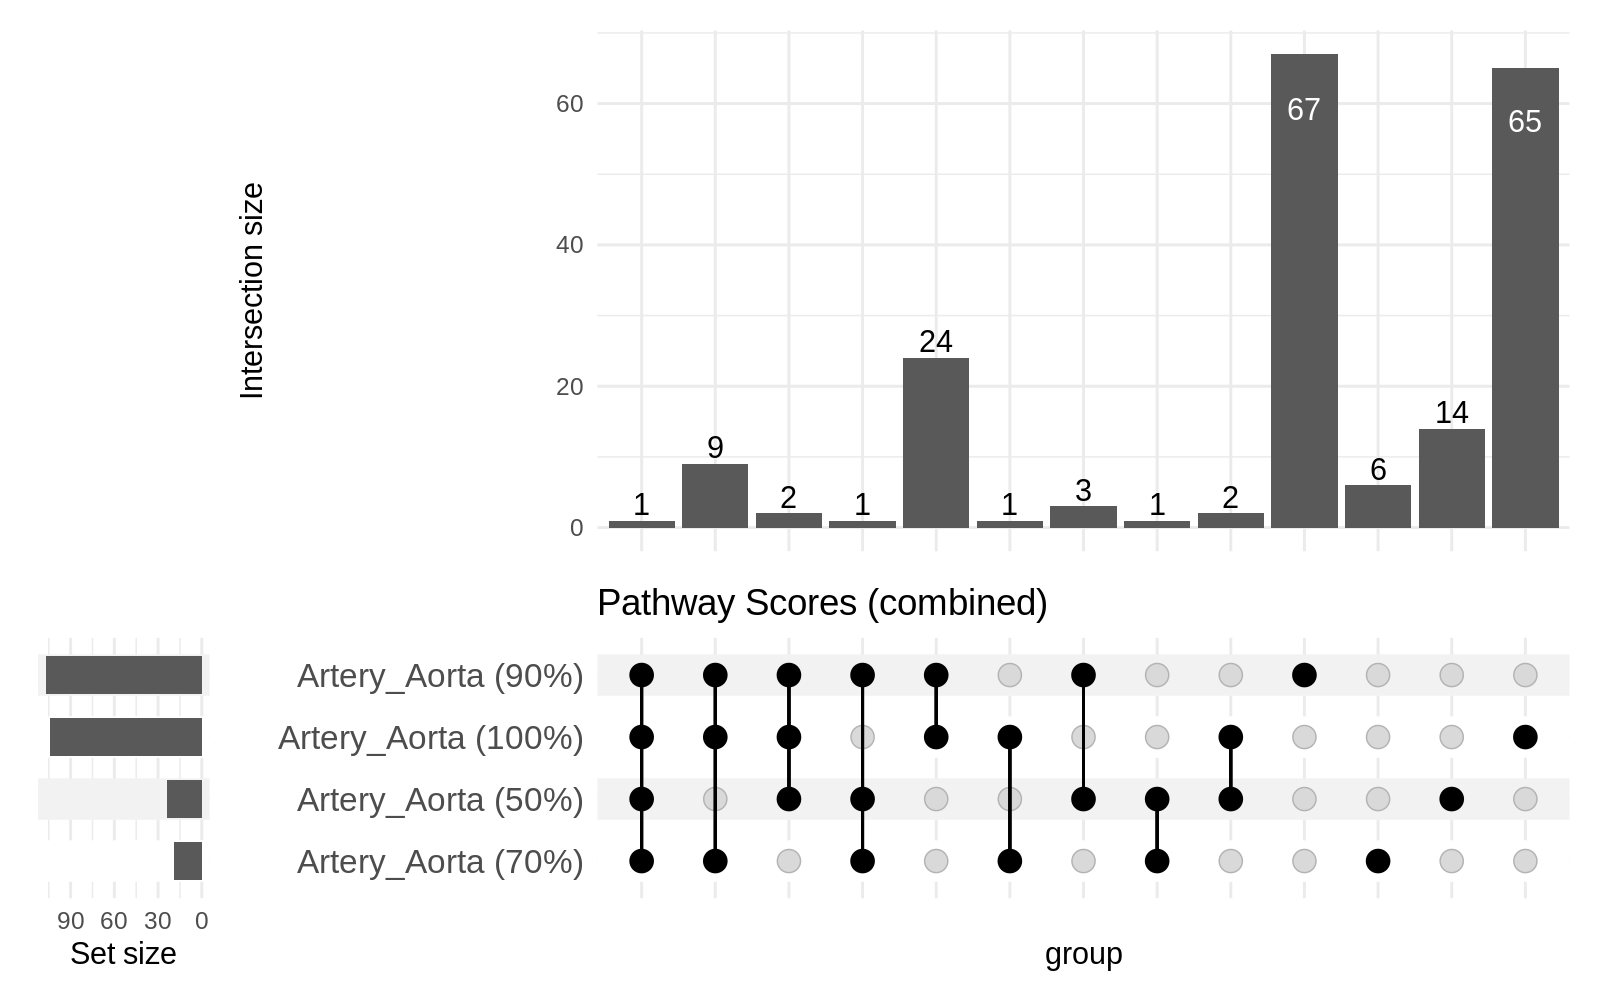

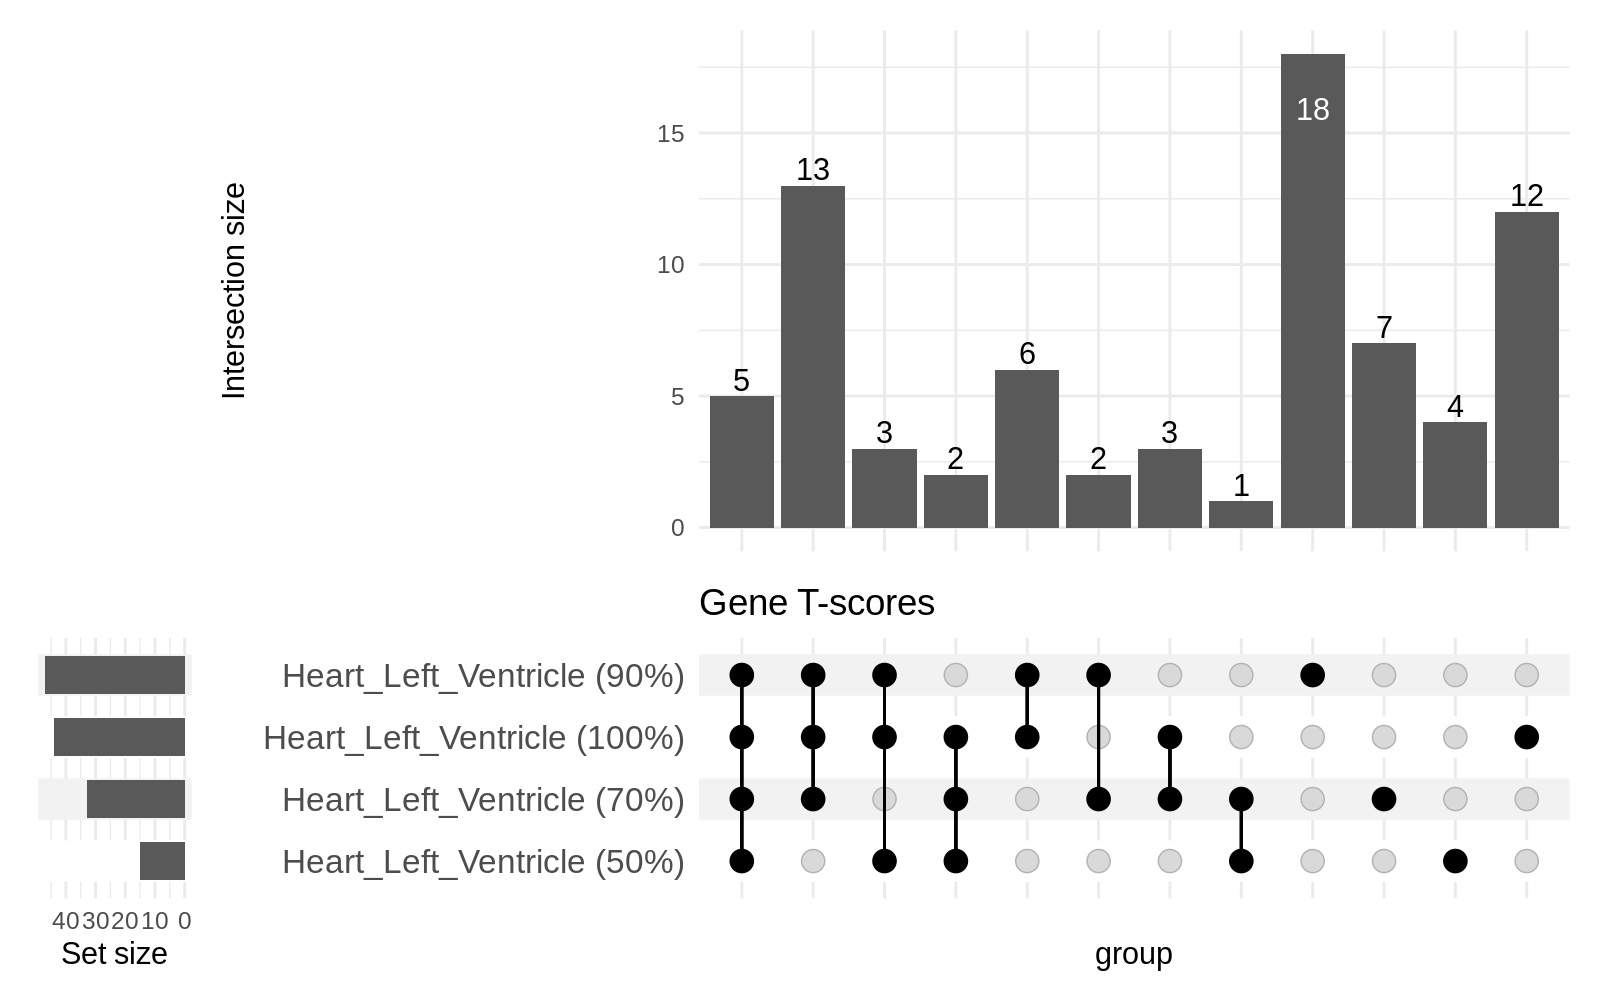

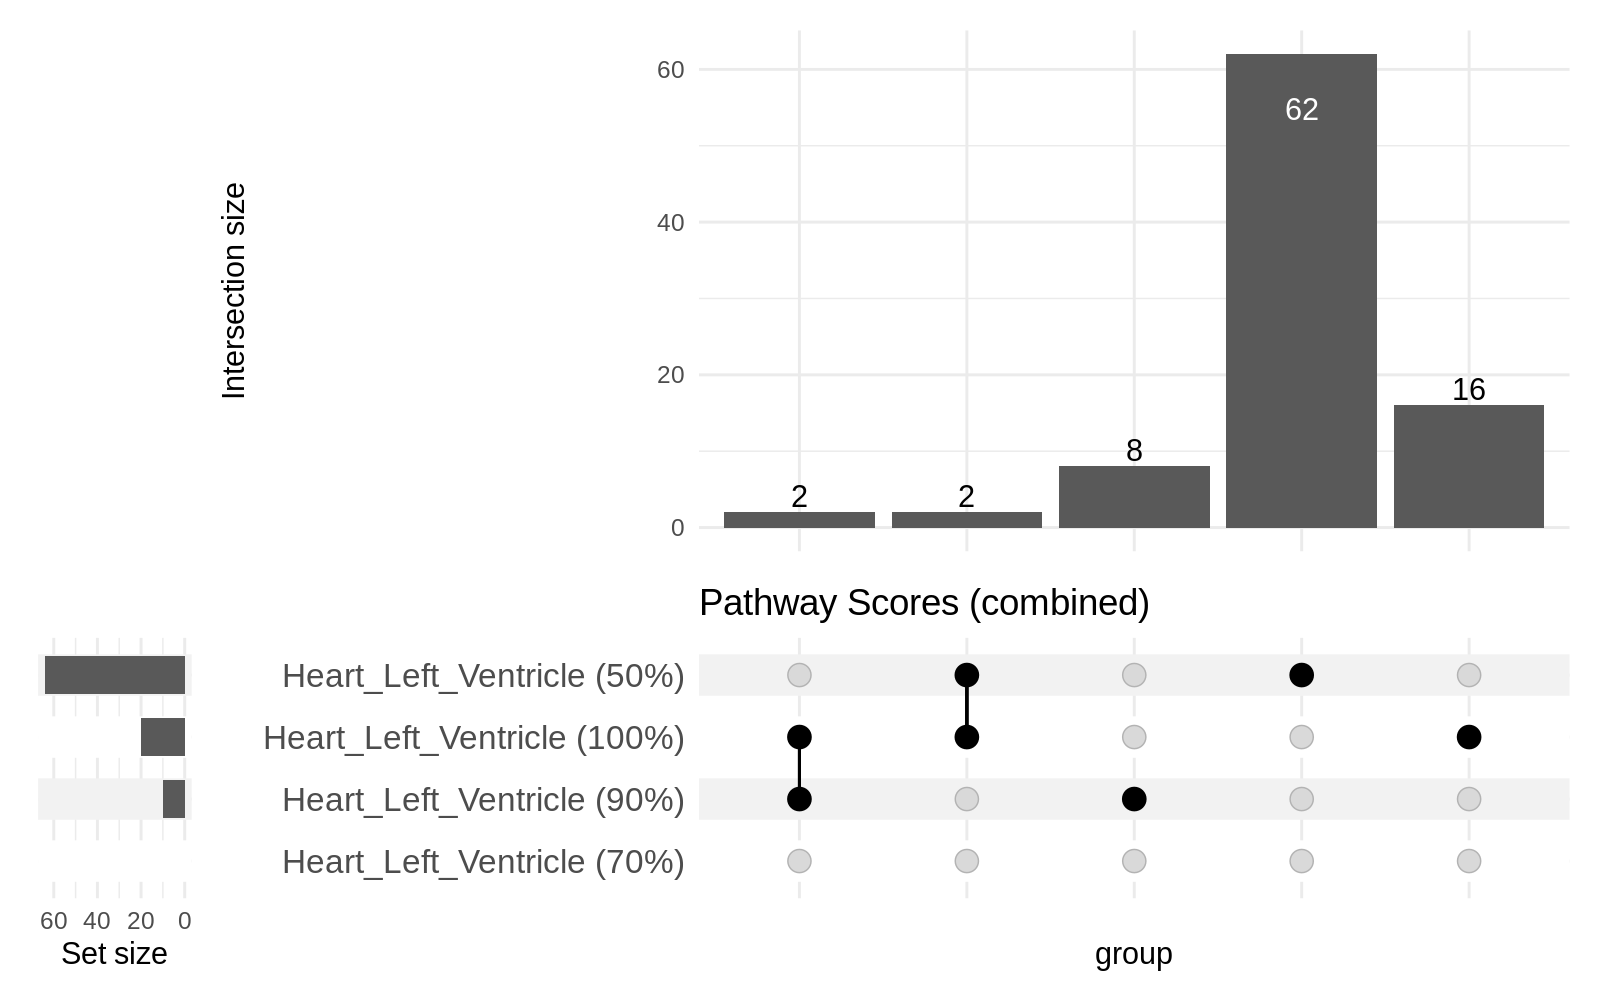

In [26]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200)

plot_upset(df = tscore, type_dat = "tscore", pheno_name = "CAD_HARD", tissue_name = "Artery_Aorta", 
           title_plot = "Gene T-scores", save_file = sprintf("%sAA_upset_tscore.pdf", outFold))

plot_upset(df = path_tot, type_dat = "path", pheno_name = "CAD_HARD", tissue_name = "Artery_Aorta", 
           title_plot = "Pathway Scores (combined)", 
           save_file = sprintf("%sAA_upset_path.pdf", outFold))

plot_upset(df = tscore, type_dat = "tscore", pheno_name = "CAD_HARD", tissue_name = "Heart_Left_Ventricle", 
           title_plot = "Gene T-scores", save_file = sprintf("%sHLV_upset_tscore.pdf", outFold))

plot_upset(df = path_tot, type_dat = "path", pheno_name = "CAD_HARD", tissue_name = "Heart_Left_Ventricle", 
           title_plot = "Pathway Scores (combined)", 
           save_file = sprintf("%sHLV_upset_path.pdf", outFold), wpl = 6, hpl = 4)




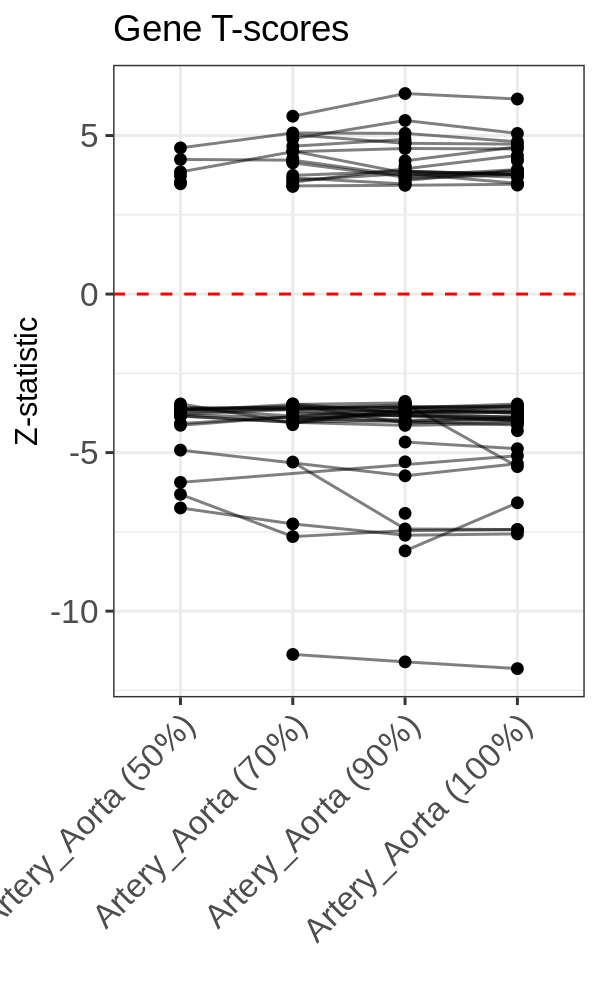

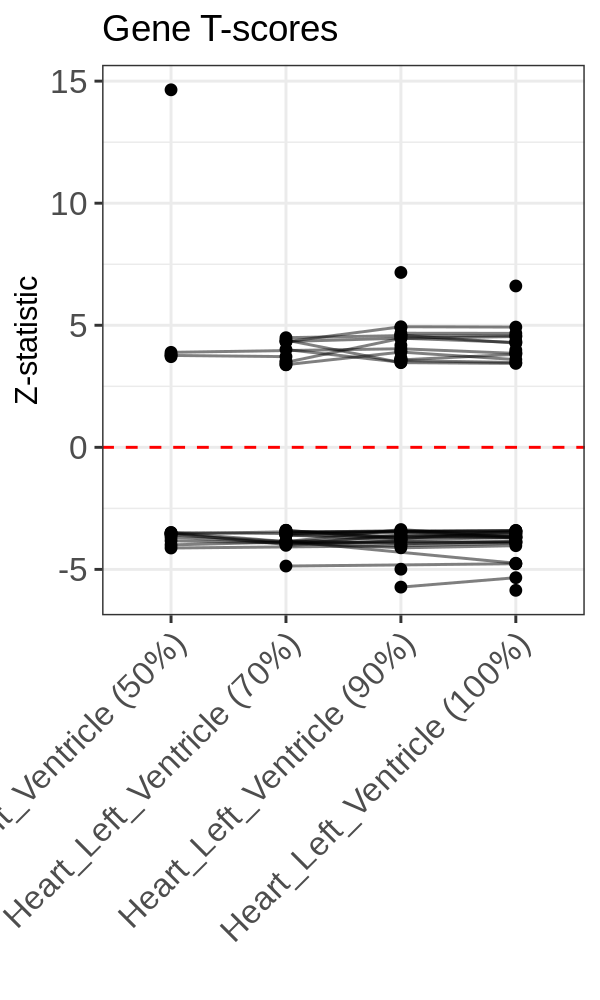

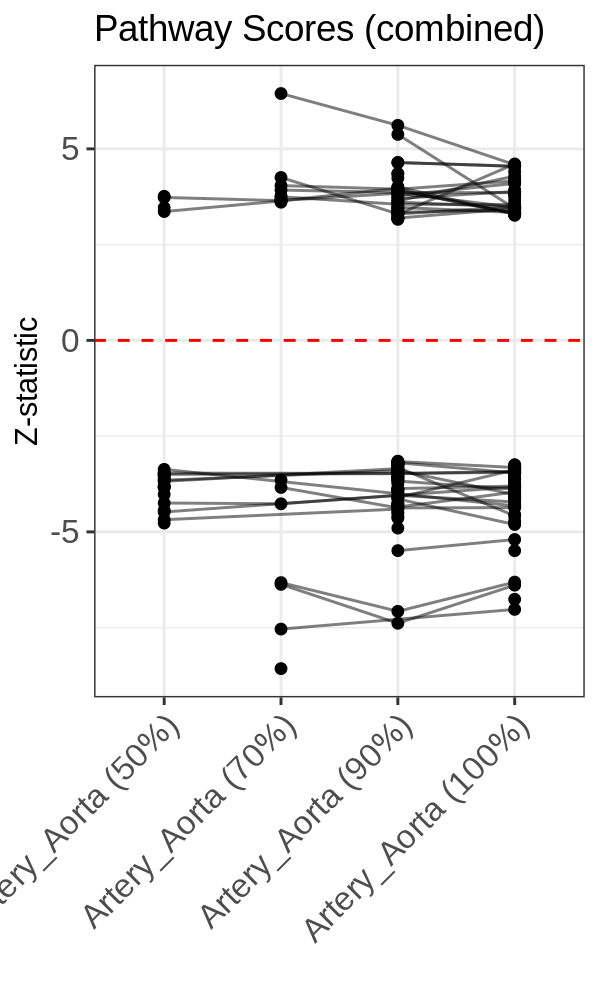

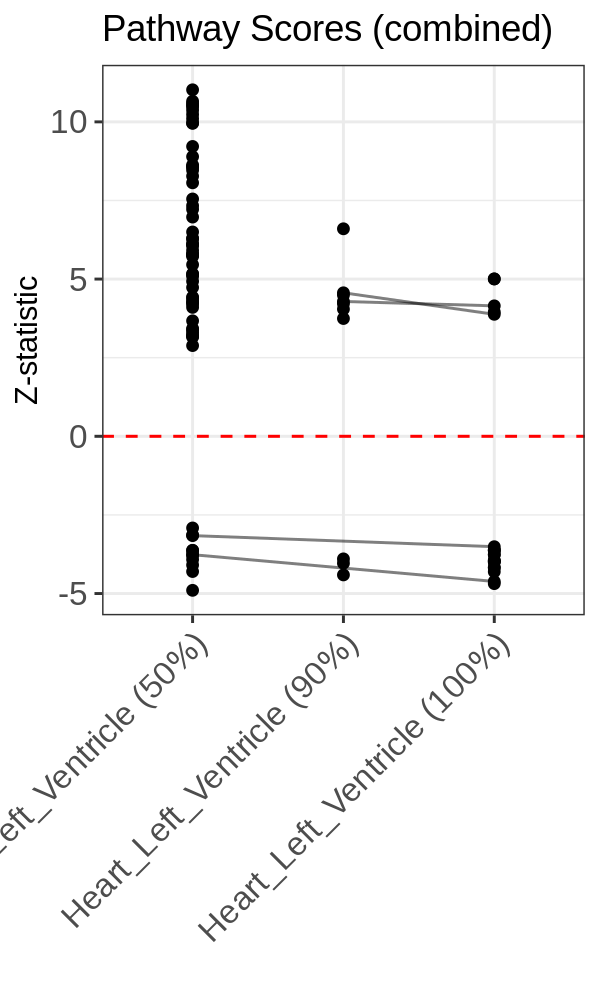

In [13]:
# plot genes and pathways in common
options(repr.plot.width = 3, repr.plot.height = 5, repr.plot.res = 200)

plot_zstat <- function(df, type_dat, title_plot, pheno_name, tissue_name, save_file = NULL, hpl = 4, wpl = 8){
    
    tmp <- df %>% 
        dplyr::filter(grepl(tissue_name, tissue), 
                      get(sprintf("%s_BHcorr", pheno_name)) <= 0.05)
    
    if(type_dat == "tscore"){
        id <- "ensembl_gene_id"
    }else{
        id <- "path"
    }
    
    tmp$tissue <- factor(tmp$tissue, levels = tissues_model$tissue[grepl(tissue_name,tissues_model$tissue)])

    pl <- ggplot(tmp, aes(x = tissue, y = get(sprintf("%s_z_t", pheno_name)), group = get(id))) +
        geom_point() + 
        geom_line(alpha = 0.5) + 
        geom_hline(yintercept = 0, linetype = "dashed", color = "red") + 
        theme_bw() + 
        xlab("") + 
        ylab("Z-statistic") + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
              axis.text = element_text(size = 12)) + 
    ggtitle(title_plot)
    
      if(!is.null(save_file)){
        ggsave(pl, filename = save_file, width = wpl, height = hpl)
    }
    
    return(pl)
    
}

plot_zstat(df = tscore, type_dat = "tscore", title_plot = "Gene T-scores", 
           pheno_name = "CAD_HARD", tissue_name = "Artery_Aorta", 
           save_file = sprintf("%sAA_zstat_tscore.pdf", outFold), wpl = 3, hpl = 5)

plot_zstat(df = tscore, type_dat = "tscore", title_plot = "Gene T-scores", 
           pheno_name = "CAD_HARD", tissue_name = "Heart_Left_Ventricle", 
           save_file = sprintf("%sHLV_zstat_tscore.pdf", outFold), wpl = 3, hpl = 5)

plot_zstat(df = path_tot, type_dat = "path", title_plot = "Pathway Scores (combined)", 
           pheno_name = "CAD_HARD", tissue_name = "Artery_Aorta", 
           save_file = sprintf("%sAA_zstat_path.pdf", outFold), wpl = 3, hpl = 5)

plot_zstat(df = path_tot, type_dat = "path", title_plot = "Pathway Scores (combined)", 
           pheno_name = "CAD_HARD", tissue_name = "Heart_Left_Ventricle", 
           save_file = sprintf("%sHLV_zstat_path.pdf", outFold), wpl = 2.5, hpl = 5)

In [82]:
ggrocs <- function(rocs, breaks = seq(0,1,0.2), legendTitel = "Legend") {
  if (length(rocs) == 0) {
    stop("No ROC objects available in param rocs.")
  } else {
    require(plyr)
    # Store all sensitivities and specifivities in a data frame
    # which an be used in ggplot
    RocVals <- plyr::ldply(names(rocs), function(rocName) {
      if(class(rocs[[rocName]]) != "roc") {
        stop("Please provide roc object from pROC package")
      }
      data.frame(
        fpr = rev(rocs[[rocName]]$specificities),
        tpr = rev(rocs[[rocName]]$sensitivities),
        names = rep(rocName, length(rocs[[rocName]]$sensitivities)),
        stringAsFactors = T
      )
    })
    
    auc_single <- data.frame(auc = sapply(rocs, "[[", "auc"), 
                             x = rep(0.2, length(rocs)), 
                             y = rev((1:length(rocs))/10), 
                             names = names(rocs))

    rocPlot <- ggplot(RocVals, aes(x = fpr, y = tpr, colour = names)) +
      geom_segment(aes(x = 0, y = 1, xend = 1,yend = 0), alpha = 0.5, colour = "black", linetype = "dashed") + 
      geom_step() +
      scale_x_reverse(name = "False Positive Rate (1 - Specificity)",limits = c(1,0), breaks = breaks) + 
      scale_y_continuous(name = "True Positive Rate (Sensitivity)", limits = c(0,1), breaks = breaks) +
      theme_bw() + 
      coord_equal() + 
      geom_text(data = auc_single, vjust = 0,
                 mapping = aes( 
                   x = x, 
                   y = y, 
                   label = paste("AUC =", sprintf("%.3f",auc)), 
                   color = names)) +
      guides(colour = guide_legend(legendTitel)) +
      theme(axis.ticks = element_line(color = "black"), 
            legend.text = element_text(size = 10),
            legend.position = "right", 
            axis.text = element_text(size = 11))
    
    rocPlot
  }
}

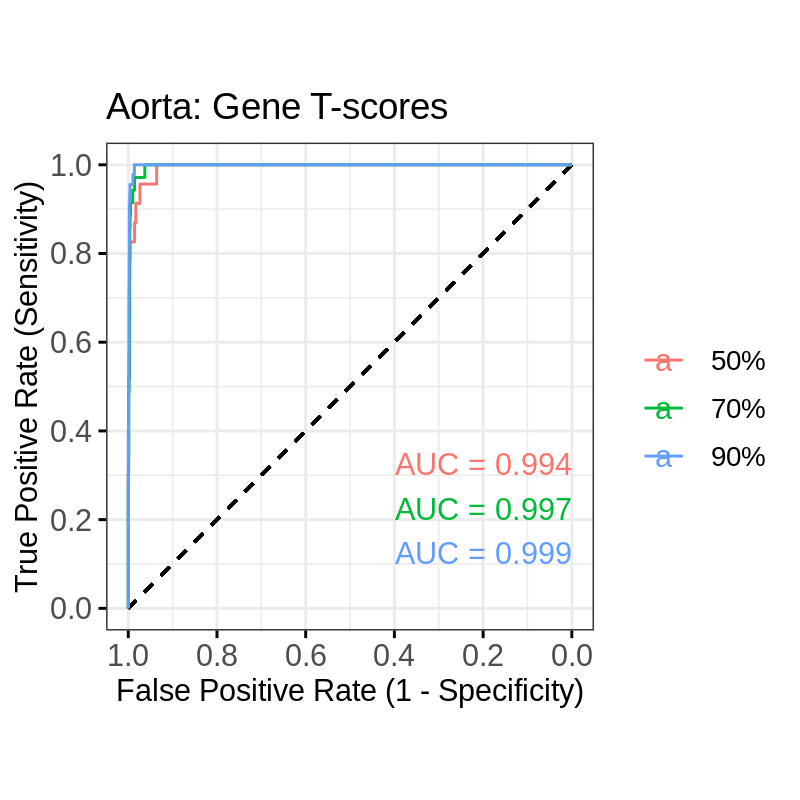

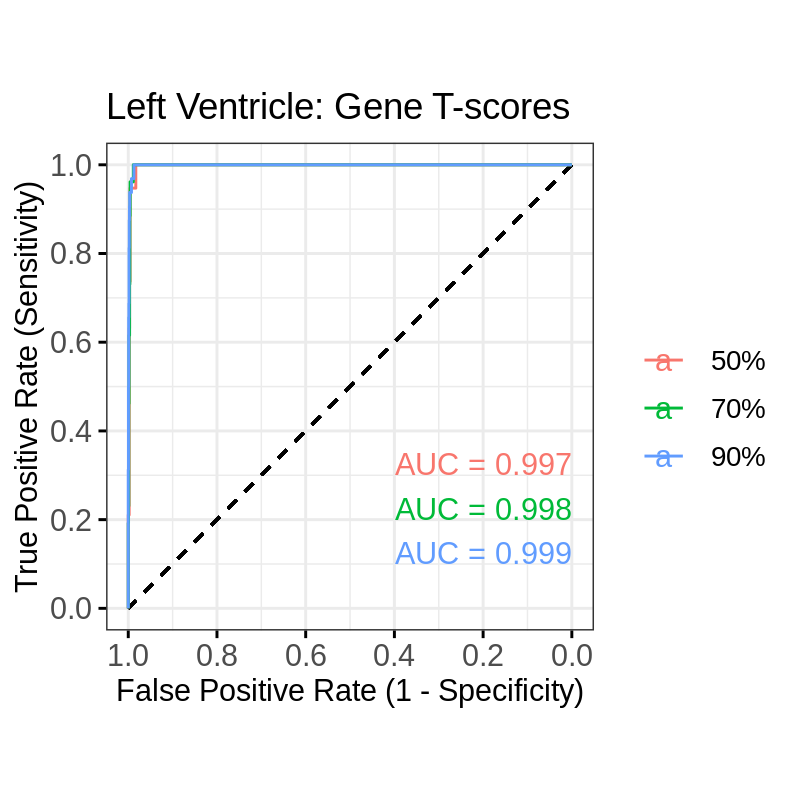

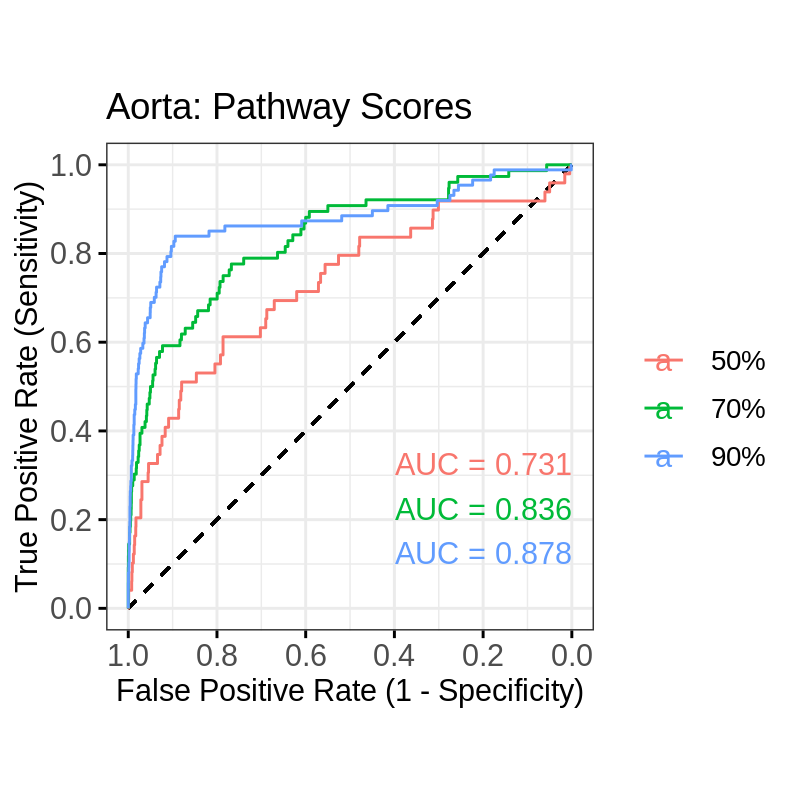

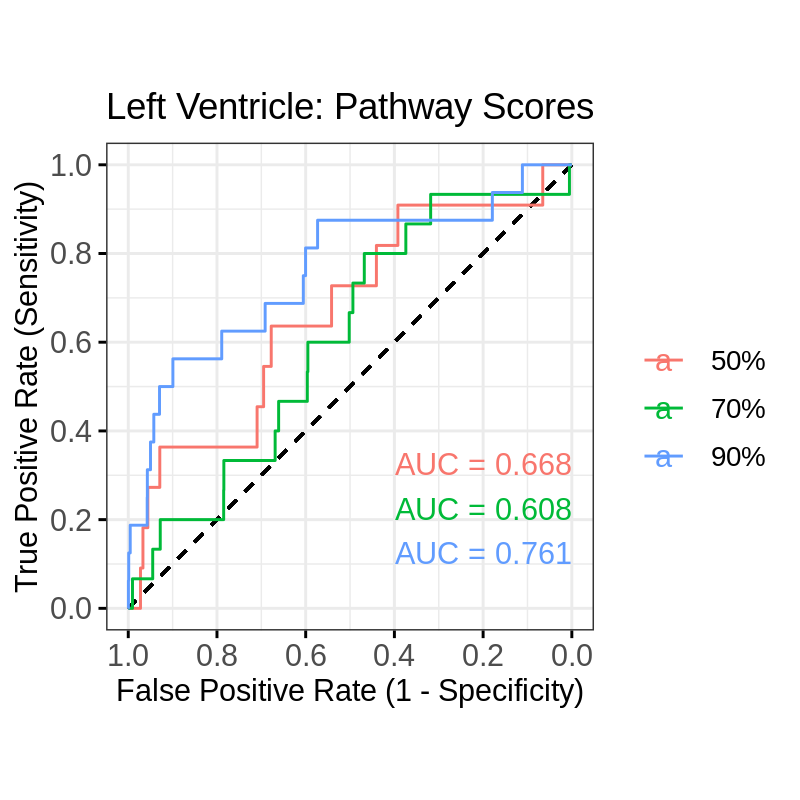

In [83]:
library(pROC)
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 200)

compute_auc <- function(tissue_name, title_plot, input, save_file){
    
    if(grepl("Gene", title_plot)){
        id <- "ensembl_gene_id"
    }else{
        id <- "path"
    }
    
    base_tissue <- paste(tissue_name, "(100%)")
    other_tissue <- setdiff(tissues_id[grepl(tissue_name, tissues_id)], base_tissue)

    input_base <- input[input$tissue == base_tissue, ]
    rocobj <- list()

    for(i in 1:length(other_tissue)){
        input_comp <- input[input$tissue == other_tissue[i], ]
        common_feat <- intersect(input_base[,id], input_comp[,id])
        tmp_base <- input_base[match(common_feat, input_base[,id]),]
        tmp_comp <- input_comp[match(common_feat, input_comp[,id]),]
        class_base <- as.numeric(tmp_base$CAD_HARD_BHcorr <= 0.05)
        absz_comp <- abs(tmp_comp$CAD_HARD_z_t)
        rocobj[[i]] <- roc(class_base, absz_comp, quiet = T)
    }
    tmp <- stringr::str_remove_all(other_tissue, "[()]")
    names(rocobj) <- stringr::str_replace(tmp, pattern = tissue_name, replacement = "")

    pl <- ggrocs(rocobj, legendTitel = "") + 
        ggtitle(title_plot)
    print(pl) 
    ggsave(plot = pl, filename = save_file, device = 'pdf', width = 4, height = 4)
    
}

compute_auc(tissue_name = "Artery_Aorta", 
            title_plot = "Aorta: Gene T-scores", 
            input = tscore, 
            save_file = sprintf("%sAA_ROC_tscore.pdf", outFold))

compute_auc(tissue_name = "Heart_Left_Ventricle", 
            title_plot = "Left Ventricle: Gene T-scores", 
            input = tscore, 
            save_file = sprintf("%sHLV_ROC_tscore.pdf", outFold))


compute_auc(tissue_name = "Artery_Aorta", 
            title_plot = "Aorta: Pathway Scores", 
            input = path_tot, 
            save_file = sprintf("%sAA_ROC_path.pdf", outFold))

compute_auc(tissue_name = "Heart_Left_Ventricle", 
            title_plot = "Left Ventricle: Pathway Scores", 
            input = path_tot, 
            save_file = sprintf("%sHLV_ROC_path.pdf", outFold))
